In [1]:
from ipynb.fs.full.general_functions import *
from ipynb.fs.full.hough import hough_circles

#PATH = "../PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"
#PATH = "../samples/normal/blood_smear_2.JPG"
PATH = "../samples/normal/blood_smear_1.JPG"
#PATH = "../samples/aglomerado/blood_smear_14.JPG"


# OTSU + HoughCircles (Method 2)

## Junta o resultado do OTSU com o HoughCircles

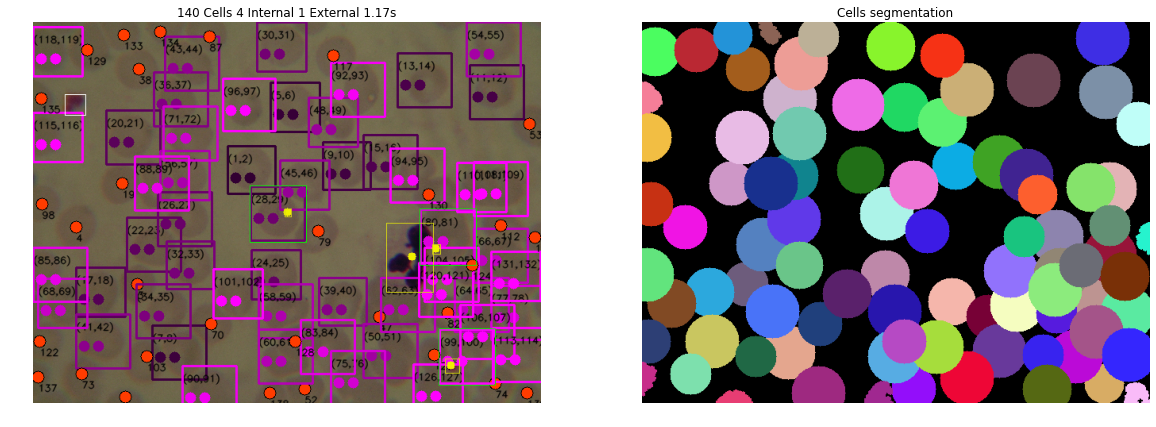

In [3]:
MAX_CELL_AREA = 3700

def union_method(path, validation_type, mark_parasites=True):
    """
    Returns: (img, cell_mask_colored), (cells, internal, external, passTime)
    """
    start = time.time()
    #read in grayscale
    imgGS = get_image(path=path)
    #read in colors
    img = get_image(path=path,mode=1)
    
    
    
    mask1 = otsu(imgGS)
    #mask1 = unet.predict(img)
        
    par_mask, par_mask_dilated = hsv_par_mask(img)
    #par_mask = gs_parasite_mask(imgGS)
    mask1 = remove_parasites(mask1,par_mask)
    mask1 = fill_holes(mask1)
    mask1 = break_big_groups(mask1)
    colored1 = colorize(mask1)
    
    
    #hough
    mask2 = cv2.adaptiveThreshold(imgGS,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,301,0)
        
    mask2 = cv2.medianBlur(mask2, 5)
    mask2 = remove_parasites(mask2,par_mask)
    components = hough_circles(mask2)
    (colored2, numLabels2, labels2, stats2, centroids2) = components
    
    #merge results
    output = cv2.connectedComponentsWithStats(mask1, 4, cv2.CV_32S)
    (numLabels1, labels1, stats1, centroids1) = output
    
    used = []
    
    
#     new_mask = np.zeros(img.shape)
#     for i in range(numLabels2):
#         R = stats2[i, cv2.CC_STAT_WIDTH]//2
#         centroid2 = (int(centroids2[i][0]), int(centroids2[i][1]))
#         cv2.circle(mask1, centroid2, R, 0, 2)
#         cv2.circle(mask1, centroid2, R-5, 255, -1)

#     #plt.imshow(mask1)
#     #plt.show()
#     img, cells = mark_cells(img,mask=mask1)
#     img, internal, external = mark_parasites(img, par_mask , mask1)
#     colored2 = colorize(mask1)
    
    #pula o primeiro do ostu
    numLabels1 -= 1
    labels1    = np.delete(labels1,0,axis=0)
    stats1     = np.delete(stats1,0,axis=0)
    stats1.reshape((numLabels1,5))
    centroids1 = np.delete(centroids1,0,axis=0)
    
    
    #para todos os grupos grandes encontrados no otsu,
    #decrementa a quantidade de circulos encontrados
    for i in range(numLabels1):
        x1 = stats1[i, cv2.CC_STAT_LEFT]
        y1 = stats1[i, cv2.CC_STAT_TOP]
        w1 = stats1[i, cv2.CC_STAT_WIDTH]
        h1 = stats1[i, cv2.CC_STAT_HEIGHT]
        area1 = stats1[i, cv2.CC_STAT_AREA]
        centroid1 = (int(centroids1[i][0]), int(centroids1[i][1]))
        #se for um conjunto de celulas, decrementa a quantidade de circulos encontrados
        #dentro da area
        if MAX_CELL_AREA < area1:
            for c in range(numLabels2):
                if x1 < centroids2[c][0] < x1+w1 and y1 < centroids2[c][1] < y1+h1:
                    r = stats2[c, cv2.CC_STAT_WIDTH]//2
                    cv2.circle(mask1, centroids2[c], r, (0,0,0), -1)
                    
    
    output = cv2.connectedComponentsWithStats(mask1, 4, cv2.CV_32S)
    (numLabels1, labels1, stats1, centroids1) = output
    
    numLabels1 -= 1
    labels1    = np.delete(labels1,0,axis=0)
    stats1     = np.delete(stats1,0,axis=0)
    stats1.reshape((numLabels1,5))
    centroids1 = np.delete(centroids1,0,axis=0)
    
    # com todos os grupos que sobraram, adiciona na mascara do hough
    ##realiza a correlação entre os pontos do otsu com os do hough
    for i in range(numLabels1):
        x1 = stats1[i, cv2.CC_STAT_LEFT]
        y1 = stats1[i, cv2.CC_STAT_TOP]
        w1 = stats1[i, cv2.CC_STAT_WIDTH]
        h1 = stats1[i, cv2.CC_STAT_HEIGHT]
        area1 = stats1[i, cv2.CC_STAT_AREA]
        centroid1 = (int(centroids1[i][0]), int(centroids1[i][1]))
        
        if MIN_CELL_AREA < area1:
            
            #se nao encontrar nenhum item proximo o suficiente
            #insere na mascara do hough
            if (np.sum(colored2[int(centroids1[i][1]), int(centroids1[i][0])]) == 0):
                cut = mask1[y1:y1+h1,x1:x1+w1]
                cut = get_principal_components(cut)
                color = random_color()
                colored_cut = colored2[y1:y1+h1,x1:x1+w1]
                colored_cut[cut == 255] = color
                
                label = np.zeros(colored_cut.shape,dtype='uint8')
                label[cut==255] = color
                #complementa os components
                numLabels2 += 1
                labels2.append(cut)
                stats2 = np.append(stats2,stats1[i]).reshape(numLabels2, 5)
                centroids2.append(centroids1[i])
                
                
    ## empacota
    components = (colored2, numLabels2, labels2, stats2, centroids2)
    
    ## mark
    img, cells = mark_cells(img,mask=None,components=components,validation_type=validation_type)#,validation_step=False)
    if mark_parasites:
        img, internal, external = parasites_mark(img, par_mask ,None, components)
    else:
        internal, external = 0,0

    end = time.time()


    passTime = "%.2fs" % (end-start)
    
    #save results
    save_results(path, "OTSU + Hough method 2 merge",cells,internal,external, passTime, img, "_otsu_hough_2_merge", validation_type)
    
    return (img, colored2), (cells, internal, external, passTime)



if __name__ == '__main__':
    #PATH = "./samples/aglomerado/blood_smear_9.JPG"
    PATH = "../samples/normal/blood_smear_1.JPG"
    images, stats = union_method(PATH, UNET_VALIDATION)
    img, cell_mask = images
    cells, internal, external, passTime = stats 


    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()